In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

---
# A notebook to train the fwrf on synthetic vision and imagery voxel responses.
---
<a id='back_to_top'></a>

## Major sections
* [0. Preliminary Setup](#prim_setup)                       
* [1. Build the synthetic brain construction](#construction)  
* [2. Train the linear hierachical generative model whose latent variables approximate this construction](#training)
* [3. Generate synthetic activities for vision](#vision)
* [4. Generate synthetic brain activations for different conditions](#activities)
* [5. Signal and noise characteristics](#snr)
* [6. Encoding model](#encoding)
* [7. Results](#result)

In [27]:
import src.gaussian_inference as aaa
reload(aaa)

<module 'src.gaussian_inference' from 'src/gaussian_inference.py'>

In [28]:
import sys
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import time

from src.gaussian_inference import *
import src.load_data as load
import src.plots as pp
import src.feature_space as fs
import src.fwrf as fwrf
import src.numpy_utility as pnu

%matplotlib inline

In [3]:
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 32.0, 'axes.titlesize': 36.0, 'legend.fontsize': 32.0,\
                                'xtick.labelsize': 28.0, 'ytick.labelsize': 28.0})
sns.set_palette("deep")

In [4]:
saveext = ".pdf"
savearg = {'format':'pdf', 'dpi': 300, 'frameon': False}

In [5]:
model_name = 'linear-gaussian'
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())

root_dir   = os.getcwd() + '/'
output_dir = root_dir+"output/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print "Time Stamp: %s" % timestamp

Time Stamp: Mar-09-2020_1326


In [6]:
cifar_root = "/home/styvesg/Documents/PostDoc/Datasets/cifar-10/"
from src.load_images import load_cifar10, standardize

## Load the stimulus dataset

In [7]:
stim_data, label_data, label_map, trn_size = load_cifar10(cifar_root, npc=1)
stim_data -= np.mean(stim_data)

npc = stim_data.shape[1] # # of channels in image
npx = stim_data.shape[2] # # of pixels width/height of images 
nx = npx*npx*npc         # # of dimensions in X
ny = len(label_map)      # # of classes
print "color = %d, resolution = %dpix, input size= %d features, class = %d" % (npc, npx, nx, ny)
print "label=", label_map

loading data_batch_1...
loading data_batch_2...
loading data_batch_3...
loading data_batch_4...
loading data_batch_5...
loading test_batch...
color = 1, resolution = 32pix, input size= 1024 features, class = 10
label= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


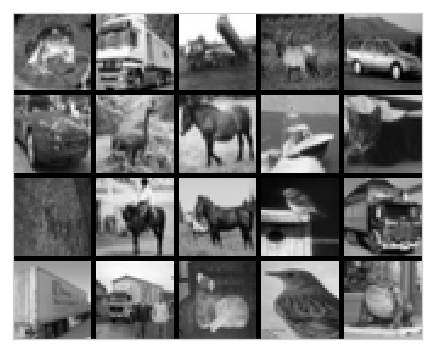

In [8]:
plt.figure(figsize=(10,6))
plt.imshow(pnu.mosaic_vis(standardize(stim_data[:20,...]), pad=2), interpolation='None', cmap='gray')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

# Spliting the training set
## Generative training, and encoding training and validation sets

In [9]:
gen_size = trn_size
gen_tst_size = 10000
gen_stim_data        = stim_data

enc_size = len(stim_data)-trn_size
enc_trn_size = 8000
enc_val_size = enc_size-enc_trn_size

enc_stim_data        = stim_data[-enc_size:]

<a id='construction'></a>
# 1. Let's build a fake brain with constructed simple cell receptive fields responses
First, sample the receptive fields from predefined distributions.

[back to top](#back_to_top)

In [10]:
complex_cell = True
symmetric    = False

In [11]:
grid0 = (np.meshgrid(np.linspace(-.5, .5, 32), np.linspace(-.5, .5, 32))) # base grid determine the coordinate system of the stimulus.
grid1 = spiderweb(rulespace(lambda x: np.power(x,.9), 0.045, .55,  28)) # 36
grid2 = spiderweb(rulespace(lambda x: np.power(x,.9), 0.045, .50, 24))
grid3 = spiderweb(rulespace(lambda x: np.power(x,.9), 0.035, .40, 20))
grid4 = spiderweb(rulespace(lambda x: np.power(x,1.), 0.030, .30, 16))
grid5 = spiderweb(rulespace(lambda x: np.power(x,1.), 0.020, .20, 12))
grid_stack    = [grid1, grid2, grid3, grid4, grid5]
#
size_fn_1 = size_ft(0.02, 1., a=.025, b=0.0, va=.25, vb=.05 )
size_fn_2 = size_ft(0.02, 1., a=.150, b=0.0, va=.25, vb=.05 ) 
size_fn_3 = size_ft(0.03, 1., a=.300, b=0.0, va=.25, vb=.05 )
size_fn_4 = size_ft(0.04, 1., a=.400, b=.10, va=.25, vb=.05 ) 
size_fn_5 = size_ft(0.05, 1., a=.700, b=.15, va=.25, vb=.05 )
size_fn_stack = [size_fn_1, size_fn_2, size_fn_3, size_fn_4, size_fn_5]
# how is frequency tied to size??

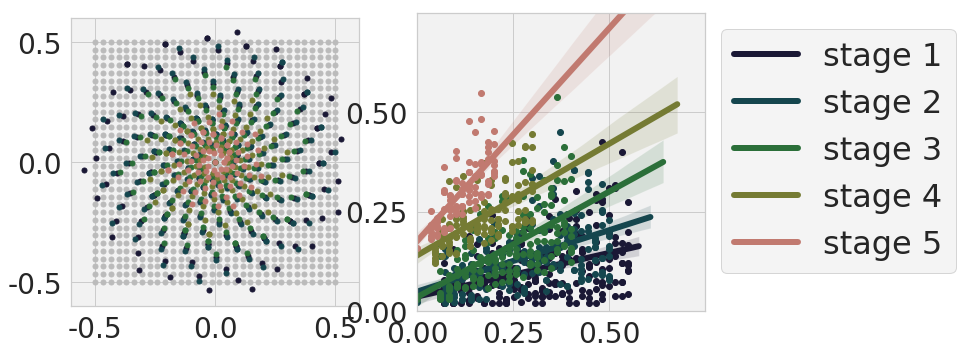

In [12]:
fig1=plt.figure(figsize=(16,5))
plt.subplots_adjust(left=.15, bottom=.12, right=0.7, top=0.95, wspace=0.2, hspace=0.)
plt.subplot(1,2,1)
plt.plot(grid0[0], grid0[1], color='#bbbbbb', linestyle='none', marker='o',markersize=5)
for k,g in enumerate(grid_stack):
    plt.plot(g[0], g[1], color=sns.color_palette("cubehelix", 8)[k], linestyle='none', marker='o',markersize=5)
plt.xlim([-12./20, 12./20])
plt.ylim([-12./20, 12./20])
plt.xticks([-10./20, 0., 10./20])
plt.gca().set_xticklabels(np.array([-10, 0., 10])/20.)
plt.yticks([-10./20, 0., 10./20])
plt.gca().set_yticklabels(np.array([-10, 0., 10])/20.)
plt.gca().set_aspect('equal')
###
plt.subplot(1,2,2)
for k,(g,s) in enumerate(zip(grid_stack, size_fn_stack)):
    ecc = np.array([np.sqrt(x**2+y**2) for x,y in zip(g[0], g[1]) ])
    size = np.array([s(e, 1) for e in ecc]).flatten()
    p=plt.plot(ecc, size, linestyle='none', marker='o', color=sns.color_palette("cubehelix", 8)[k])
    sns.regplot(x=ecc, y=size, x_ci='sd', scatter=False, line_kws={'lw':6, 'color': p[0].get_color()}, label='stage %d' % (k+1))

plt.xticks([0., .25, .5])
plt.yticks([0., .25, .5])
plt.xlim([0., .75])
plt.ylim([0., .75])
plt.legend(loc='upper left', bbox_to_anchor=(1., 1.))

In [13]:
filename = output_dir + "rf_distribution_%s%s" % (timestamp, saveext)
fig1.patch.set_alpha(0.)
fig1.savefig(filename, **savearg)

In [17]:
# Receptive field construction responses.
target_RFs, true_rf_params = create_filter_stack(grid0, grid_stack, size_fn_stack, ori_per_location=4,\
        size_sample_per_location=1, complex_cell=True, symmetric=symmetric)
# partitions
partition_sizes = [len(target_RFs[0]),] + [rf.shape[1] for rf in target_RFs]
r_roi_mask, r_roi_map, r_voxel_roi, r_voxel_transitions, r_voxel_partitions = get_activity_roi(partition_sizes, complex_cell=False)
a_roi_mask, a_roi_map, a_voxel_roi, a_voxel_transitions, a_voxel_partitions = get_activity_roi(partition_sizes, complex_cell=True)
nv = np.sum(r_voxel_partitions)
print nv, "(linear)", np.sum(a_voxel_partitions), "(nonlinear)"

6120 (linear) 3060 (nonlinear)


## Display the desired receptive field properties

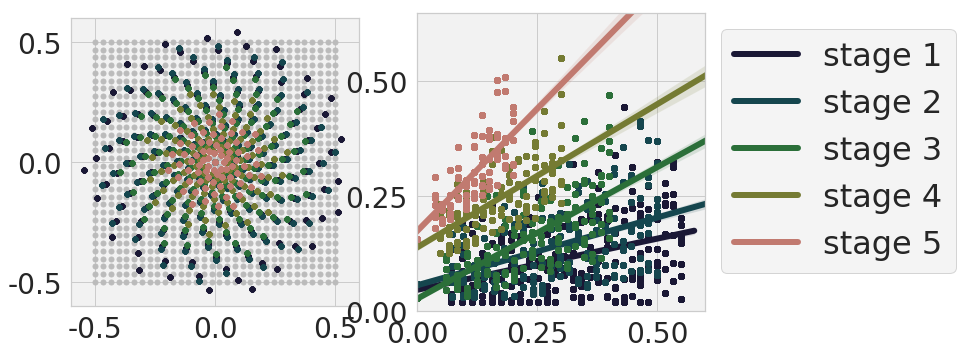

In [18]:
fig1=plt.figure(figsize=(16,5))
plt.subplots_adjust(left=.15, bottom=.12, right=0.7, top=0.95, wspace=0.2, hspace=0.)
plt.subplot(1,2,1)
plt.plot(grid0[0], grid0[1], color='#bbbbbb', linestyle='none', marker='o',markersize=5)
for k,rm in enumerate(r_roi_mask):
    plt.plot(true_rf_params[rm,0], true_rf_params[rm,1], color=sns.color_palette("cubehelix", 8)[k], linestyle='none', marker='o',markersize=5)
plt.xlim([-.6, .6])
plt.ylim([-.6, .6])
plt.xticks([-.5, 0., .5])
plt.gca().set_xticklabels(np.array([-.5, 0., .5]))
plt.yticks([-.5, 0., .5])
plt.gca().set_yticklabels(np.array([-.5, 0., .5]))
plt.gca().set_aspect('equal')
###
plt.subplot(1,2,2)
for k,rm in enumerate(r_roi_mask):  
    ecc = np.sqrt(np.square(true_rf_params[rm,0]) + np.square(true_rf_params[rm,1])) 
    size = true_rf_params[rm,2]
    p=plt.plot(ecc, size, linestyle='none', marker='o', color=sns.color_palette("cubehelix", 8)[k])
    sns.regplot(x=ecc, y=size, x_ci='sd', scatter=False, line_kws={'lw':6, 'color': p[0].get_color()}, label='stage %d' % (k+1))
plt.xticks([0., .25, .5])
plt.yticks([0., .25, .5])
plt.xlim([0,.60])
plt.ylim([0,.65])
plt.legend(loc='upper left', bbox_to_anchor=(1., 1.))

In [19]:
filename = output_dir + "rf_distribution_%s%s" % (timestamp, saveext)
fig1.patch.set_alpha(0.)
fig1.savefig(filename, **savearg)

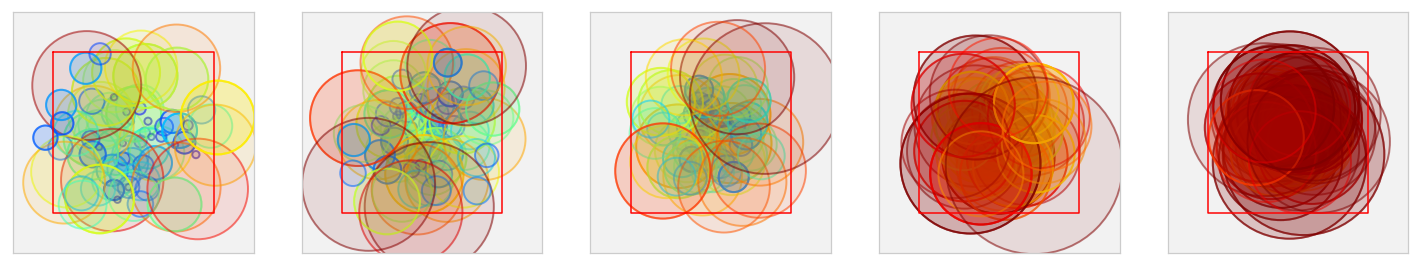

In [20]:
target_nvox = 120
lx = float(1)

from scipy.stats import rv_discrete
_pruning_dist = lambda x: rv_discrete(name='custm', values=([0,1], [x, 1-x]))
fig=plt.figure(figsize=(5*len(r_roi_mask), 5))   

for roi,rm in enumerate(r_roi_mask):
    plt.subplot(1,len(r_roi_mask), roi+1)
    roi_nvox = np.sum(rm)
    prune_frac = max(0, float(roi_nvox - target_nvox)) / roi_nvox
    if prune_frac==0:
        print "%d>%d in roi %d" % (target_nvox, r_roi_nvox, roi)
    pruning_dist = _pruning_dist(prune_frac)
    rand_mask = pruning_dist.rvs(size=rm.shape)    
    mask = np.logical_and(rm, rand_mask)         
    pp.plot_rf_as_circles(true_rf_params[mask,:3], 0, .35)
    plt.plot([-lx/2,lx/2,lx/2,-lx/2,-lx/2], [lx/2,lx/2,-lx/2,-lx/2, lx/2], 'r')
    plt.xlim([-.75, .75])
    plt.ylim([-.75, .75])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')

<a id='training'></a>
# 2. Train the linear hierachical generative model whose latent variables approximate this construction

[back to top](#back_to_top)

In [29]:
# Infer the weights of the generative model that would produce the receptive field construction responses.
Us, Ls, val, pred, cc = infer_generative_model_params(
        target_RFs, gen_stim_data, trn_size=gen_size, tst_size=gen_tst_size, noise=0.1, num_turns=2,  ### 3
        gammas = np.logspace(3., 4, 6), z_score=True, dtype=fpX) # np.logspace(4., 5., 6) with z_score = True

line 0 :  [(1024, 1024), (1024, 1736), (1024, 1480), (1024, 1224), (1024, 968), (1024, 712)]
line 1 :  [(1736, 1024), (1736, 1736), (1736, 1480), (1736, 1224), (1736, 968), (1736, 712)]
line 2 :  [(1480, 1024), (1480, 1736), (1480, 1480), (1480, 1224), (1480, 968), (1480, 712)]
line 3 :  [(1224, 1024), (1224, 1736), (1224, 1480), (1224, 1224), (1224, 968), (1224, 712)]
line 4 :  [(968, 1024), (968, 1736), (968, 1480), (968, 1224), (968, 968), (968, 712)]
line 5 :  [(712, 1024), (712, 1736), (712, 1480), (712, 1224), (712, 968), (712, 712)]
 ===> k = 0, gamma = 1000.000000 <===
 ===> k = 1, gamma = 1584.893192 <===
 ===> k = 2, gamma = 2511.886432 <===
 ===> k = 3, gamma = 3981.071706 <===
 ===> k = 4, gamma = 6309.573445 <===
 ===> k = 5, gamma = 10000.000000 <===
Turn 0, Layer 0


6it [03:49, 38.21s/it]

  Layer 0, best gamma @ 1 (0--6) with SCORE = 7562.790504
Turn 0, Layer 1



6it [03:43, 37.21s/it]

  Layer 1, best gamma @ 2 (0--6) with SCORE = 7571.845883
Turn 0, Layer 2



6it [03:44, 37.43s/it]

  Layer 2, best gamma @ 1 (0--6) with SCORE = 7576.069408
Turn 0, Layer 3



6it [03:34, 35.82s/it]

  Layer 3, best gamma @ 2 (0--6) with SCORE = 7579.413565
Turn 0, Layer 4



6it [03:33, 35.60s/it]


  Layer 4, best gamma @ 2 (0--6) with SCORE = 7581.506135
  End of turn: avg cc = 0.993108
Turn 1, Layer 0


6it [03:33, 35.55s/it]

  Layer 0, best gamma @ 1 (0--6) with SCORE = 7581.506135
Turn 1, Layer 1



6it [03:33, 35.51s/it]

  Layer 1, best gamma @ 2 (0--6) with SCORE = 7581.506135
Turn 1, Layer 2



6it [03:35, 35.98s/it]

  Layer 2, best gamma @ 1 (0--6) with SCORE = 7581.506135
Turn 1, Layer 3



6it [03:33, 35.55s/it]

  Layer 3, best gamma @ 2 (0--6) with SCORE = 7581.506135
Turn 1, Layer 4



6it [03:32, 35.45s/it]


  Layer 4, best gamma @ 2 (0--6) with SCORE = 7581.506135
  End of turn: avg cc = 0.993108


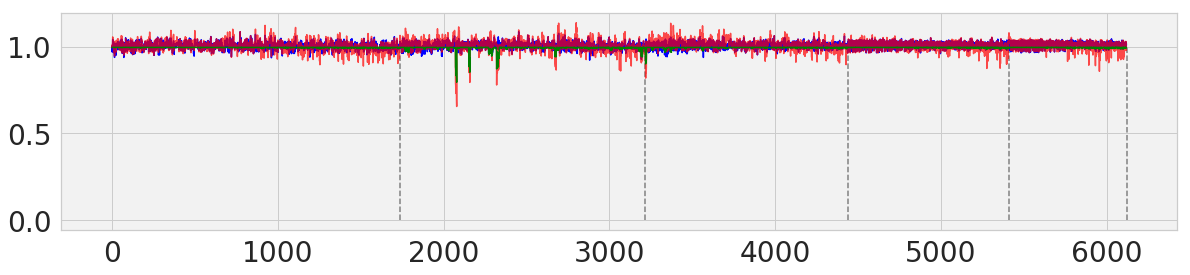

In [30]:
plt.figure(figsize=(20,4))
plt.plot(np.var(val, axis=0), color='b')
plt.plot(np.var(pred, axis=0), color='r', alpha=0.7)
plt.plot(cc, color='g')
plt.gca().vlines(np.cumsum(partition_sizes[1:]), ymin=0, ymax=1, linestyle='--', color='gray')

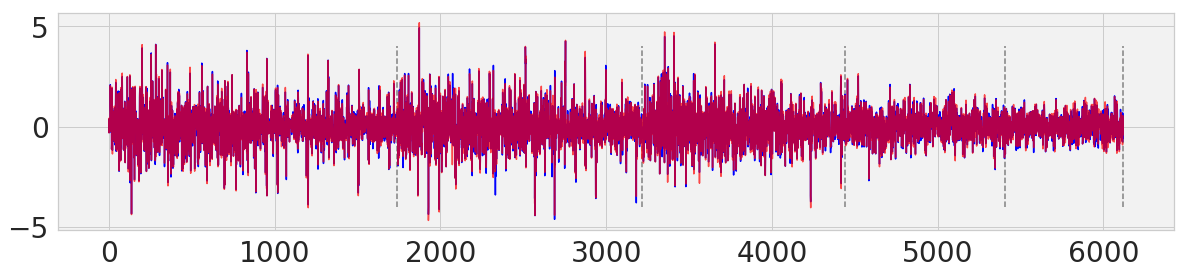

In [31]:
plt.figure(figsize=(20,4))
plt.plot(val[0,:], color='b')
plt.plot(pred[0,:], color='r', alpha=0.7)
plt.gca().vlines(np.cumsum(partition_sizes[1:]), ymin=-4, ymax=4, linestyle='--', color='gray')

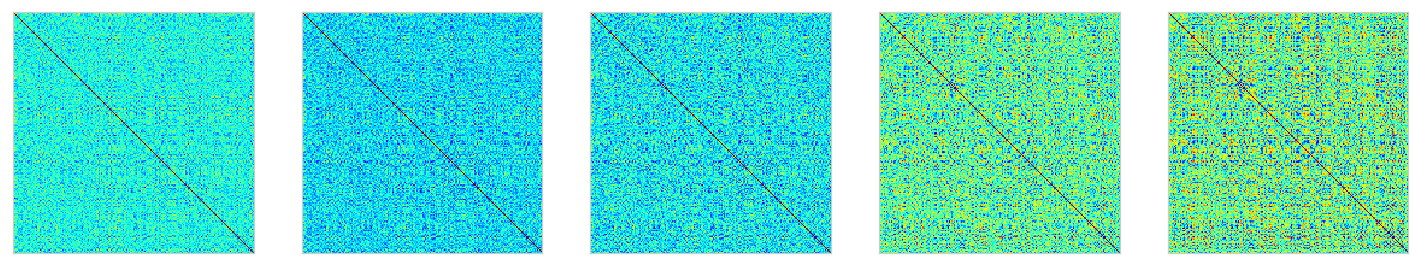

In [32]:
fig=plt.figure(figsize=(5*len(r_roi_mask), 5))   
for roi,rm in enumerate(r_roi_mask):
    plt.subplot(1,len(r_roi_mask), roi+1)
    plt.imshow(np.corrcoef(pred[:200,rm]), cmap='jet',interpolation='None')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')

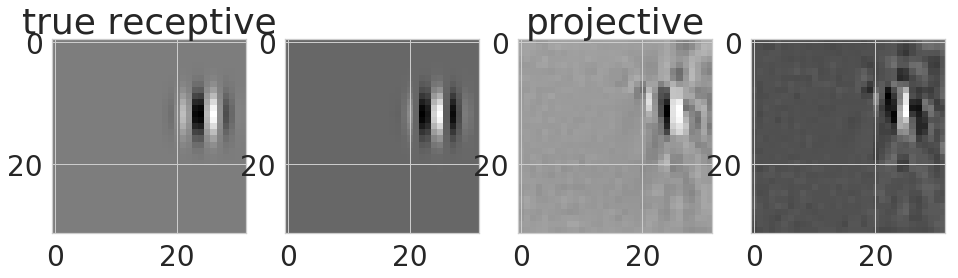

In [33]:
i = 400
###
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.imshow(target_RFs[0][:,2*i].reshape((32,32)), cmap='gray', interpolation='none')
plt.title('true receptive')
plt.subplot(1,4,2)
plt.imshow(target_RFs[0][:,2*i+1].reshape((32,32)), cmap='gray', interpolation='none')
plt.subplot(1,4,3)
plt.imshow(Us[0][:,2*i].reshape((32,32)), cmap='gray', interpolation='none')
plt.title('projective')
plt.subplot(1,4,4)
plt.imshow(Us[0][:,2*i+1].reshape((32,32)), cmap='gray', interpolation='none')

### Now, in this formulation, there is no global noise parameter to adjust, since all these parameters have been learned from the data. We will sample the linear representation 

<a id='vision'></a>

# 3. Generate synthetic activities for vision

[back to top](#back_to_top)

In [34]:
probes = enc_stim_data
# vision: equiv. to positional attention with position tracking and matching features.
activities, partition_sizes = calculate_activity_during_vision_under_different_clamping(probes, None,\
            Us, Ls, clamping_layers=None, complex_cell=complex_cell, name='vis')

calculating vision responses


### Partitioning of the layers

Text(0.5,1,'Signal and Noise level per unit (linear)')

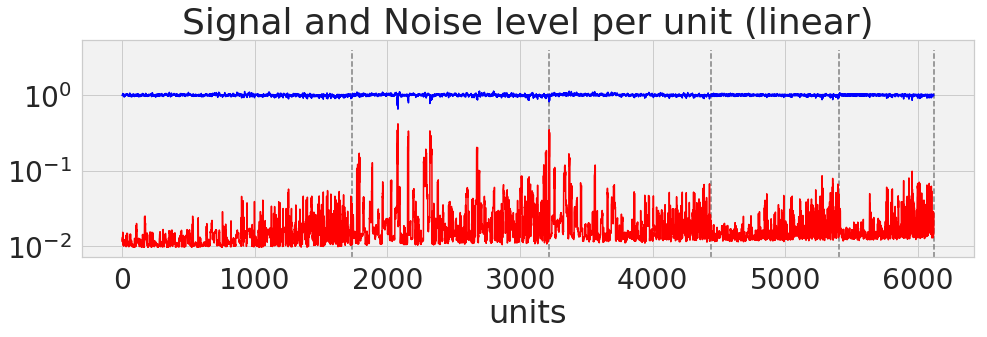

In [39]:
plt.figure(figsize=(16,4))
plt.plot(np.var(activities['vis']['r_mu'], axis=0), color='b') # variance of the mean w.r.t. the validation dataset
plt.plot(np.diag(activities['vis']['r_Sigma']), color='r') # mean of the variance of the noise
plt.gca().vlines(np.cumsum(partition_sizes[1:]), ymin=-4, ymax=4, linestyle='--', color='gray')
plt.yscale('log')
plt.xlabel('units')
plt.title('Signal and Noise level per unit (linear)')
#plt.imshow(S[-1000:,-1000:], cmap='inferno', interpolation=None)

---
<a id='activities'></a>

# 4. Generate synthetic brain activations for different conditions
Create several small synthetic brains according to a common RF specification rule and concatenate the ensuing voxels.

[back to top](#back_to_top)

In [40]:
n_model_samples = 8
n_samples = 16
probes = enc_stim_data

global_dicts = {}
global_dicts['true_rf_params'] = []
global_dicts['a_roi_mask']     = []
global_dicts['activities']     = {}
global_dicts['covariances']    = {}
for n in range(n_model_samples):
    # sample the construction model.
    target_RFs, true_rf_params = create_filter_stack(grid0, grid_stack, size_fn_stack, ori_per_location=4,\
        size_sample_per_location=1, complex_cell=True, symmetric=symmetric)   
    global_dicts['true_rf_params'] += [true_rf_params,]
    
    partition_sizes = [len(target_RFs[0]),] + [rf.shape[1] for rf in target_RFs]
    r_roi_mask, r_roi_map, r_voxel_roi, r_voxel_transitions, r_voxel_partitions = get_activity_roi(partition_sizes, complex_cell=False)
    a_roi_mask, a_roi_map, a_voxel_roi, a_voxel_transitions, a_voxel_partitions = get_activity_roi(partition_sizes, complex_cell=True)
    global_dicts['a_roi_mask']  += [a_roi_mask,]
    # infer the generative model params.
    Us, Ls, val, pred, cc = infer_generative_model_params(
        target_RFs, gen_stim_data, trn_size=gen_size, tst_size=gen_tst_size, noise=0.1, num_turns=1,  ### 3
        gammas = np.logspace(3., 4., 6), z_score=True, dtype=fpX)    
    # ----------------------------------------------------------- #
    # vision: equiv. to positional attention with position tracking and matching features.
    activities, partition_sizes = calculate_activity_during_vision_under_different_clamping(probes, None,\
                Us, Ls, clamping_layers=None, complex_cell=complex_cell, name='vis')
    activities, partition_sizes = calculate_activity_during_vision_under_different_clamping(np.zeros_like(probes), probes,\
                Us, Ls, clamping_layers=[3], complex_cell=complex_cell, name='img', store=activities, store_probes=False)
    activities, partition_sizes = calculate_activity_during_vision_under_different_clamping(np.zeros_like(probes), probes,\
                Us, Ls, clamping_layers=[4], complex_cell=complex_cell, name='img', store=activities, store_probes=False)
    activities, partition_sizes = calculate_activity_during_vision_under_different_clamping(np.zeros_like(probes), probes,\
                Us, Ls, clamping_layers=[5], complex_cell=complex_cell, name='img', store=activities, store_probes=False)   
    # ...
    for a in activities.keys():
        if a not in global_dicts['activities'].keys():
            global_dicts['activities'][a] = {}
            global_dicts['activities'][a]['a_mu']   = []
            global_dicts['activities'][a]['s_mu']  = []
            global_dicts['activities'][a]['s_cov'] = []            
        print "--- sampling %s ---" % a
        r_mu    = activities[a]['r_mu']
        r_Sigma = np.linalg.cholesky(activities[a]['r_Sigma'] + np.eye(len(activities[a]['r_Sigma']))*1e-6).T
        activity_samples = []
        for n in range(n_samples):
            activity_samples += [get_activity_sample(r_mu, r_Sigma, 1., complex_cell),]
        activity_samples = np.stack(activity_samples)
        activity_mean = np.mean(activity_samples, axis=0)
        activity_fluc = (activity_samples - activity_mean[np.newaxis]).reshape((-1,activity_samples.shape[-1]))
        global_dicts['activities'][a]['a_mu']  += [activity(r_mu, complex_cell),]
        global_dicts['activities'][a]['s_mu']  += [activity_mean,]
        global_dicts['activities'][a]['s_cov'] += [np.cov(activity_fluc.T),]
####################################################################
# Concatenate the several mini-brain samples
n_roi = len(global_dicts['a_roi_mask'][0])
a_roi_mask = [np.concatenate([global_dicts['a_roi_mask'][n][r] for n in range(n_model_samples)], axis=0) for r in range(n_roi)]
activities = {}
for a in global_dicts['activities'].keys():
    activities[a] = {}
    activities[a]['s_mu']  = np.concatenate(global_dicts['activities'][a]['s_mu'], axis=1)
    activities[a]['s_var'] = np.concatenate([np.diag(c) for c in global_dicts['activities'][a]['s_cov']], axis=0)

line 0 :  [(1024, 1024), (1024, 1736), (1024, 1480), (1024, 1224), (1024, 968), (1024, 712)]
line 1 :  [(1736, 1024), (1736, 1736), (1736, 1480), (1736, 1224), (1736, 968), (1736, 712)]
line 2 :  [(1480, 1024), (1480, 1736), (1480, 1480), (1480, 1224), (1480, 968), (1480, 712)]
line 3 :  [(1224, 1024), (1224, 1736), (1224, 1480), (1224, 1224), (1224, 968), (1224, 712)]
line 4 :  [(968, 1024), (968, 1736), (968, 1480), (968, 1224), (968, 968), (968, 712)]
line 5 :  [(712, 1024), (712, 1736), (712, 1480), (712, 1224), (712, 968), (712, 712)]
 ===> k = 0, gamma = 1000.000000 <===
 ===> k = 1, gamma = 1584.893192 <===
 ===> k = 2, gamma = 2511.886432 <===
 ===> k = 3, gamma = 3981.071706 <===
 ===> k = 4, gamma = 6309.573445 <===
 ===> k = 5, gamma = 10000.000000 <===
Turn 0, Layer 0


6it [05:30, 55.14s/it]

  Layer 0, best gamma @ 1 (0--6) with SCORE = 7585.974612
Turn 0, Layer 1



6it [05:40, 56.73s/it]

  Layer 1, best gamma @ 2 (0--6) with SCORE = 7594.725518
Turn 0, Layer 2



6it [05:36, 56.02s/it]

  Layer 2, best gamma @ 2 (0--6) with SCORE = 7599.506497
Turn 0, Layer 3



6it [05:41, 56.91s/it]

  Layer 3, best gamma @ 2 (0--6) with SCORE = 7602.832647
Turn 0, Layer 4



6it [05:36, 56.05s/it]


  Layer 4, best gamma @ 2 (0--6) with SCORE = 7604.941438
  End of turn: avg cc = 0.993241
calculating vision responses
calculating vision responses
calculating responses to clamping layer 3
calculating vision responses
calculating responses to clamping layer 4
calculating vision responses
calculating responses to clamping layer 5
--- sampling img_clamp_3 ---
--- sampling vis ---
--- sampling img_clamp_5 ---
--- sampling img_clamp_4 ---


<a id='snr'></a>

# 5. Signal and noise characteristics

[back to top](#back_to_top)

In [41]:
vref = 'vis'
cmps = ['img_clamp_3', 'img_clamp_4', 'img_clamp_5']
dspy = [vref,] + cmps
clri = {'img_clamp_3': 2, 'img_clamp_4': 3, 'img_clamp_5': 4}

(0.001, 1.2)

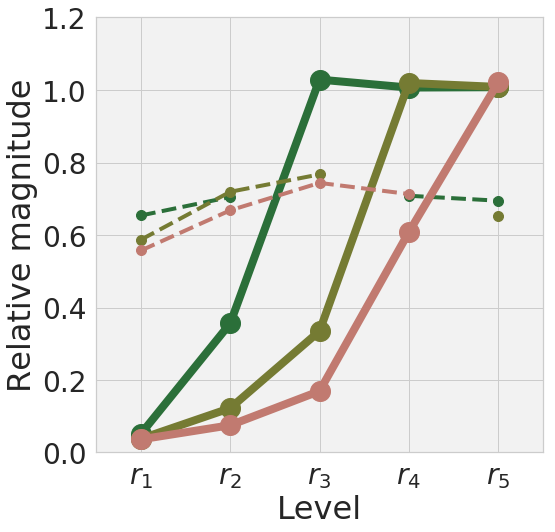

In [42]:
fig=plt.figure(figsize=(8,8))
ref_S, ref_N = activities[vref]['s_mu'], activities[vref]['s_var']
for cm in cmps:
    S, N = activities[cm]['s_mu'], activities[cm]['s_var']
    y = np.var(S, axis=0)/np.var(ref_S, axis=0)
    p=plt.plot([np.mean(y[m]) for m in a_roi_mask], color=sns.color_palette("cubehelix", 8)[clri[cm]], marker='o', ms=20, lw=8, label=cm)
    y = N/ref_N
    plt.plot([np.nan if np.mean(y[m])<1e-1 else np.mean(y[m]) for m in a_roi_mask], marker='o', ms=10, lw=4, linestyle='dashed', color=p[0].get_color())
    #plt.bar(np.arange(len(a_roi_mask))-0.4, [np.median(y[m]) for m in a_roi_mask], color=p[0].get_color(), alpha=.25)
_=plt.gca().set_xticks([0,1,2,3,4])
_=plt.gca().set_xticklabels([r'$r_1$', r'$r_2$', r'$r_3$', r'$r_4$', r'$r_5$'])
_=plt.ylabel('Relative magnitude')
_=plt.xlabel('Level')
#plt.yscale('log')
plt.xlim([-.5,4.5])
plt.ylim([1e-3,1.2])

---
<a id='encoding'></a>

# 6. Encoding Models
## Precompute global model-space tensor

[back to top](#back_to_top)

In [43]:
#def multi_generative_multi_encoding_fit(stim_data):
# inf_frac = 5./6, trn_frac = .8
# n_samples
inf_frac = 5./6
trn_frac = .8

inf_size  = int(float(len(stim_data)) * inf_frac)
ctrn_size = int(float(inf_size) * trn_frac)
ctst_size = inf_size-ctrn_size
vtrn_size = int(float(len(stim_data)-inf_size) * trn_frac)
ho_size   = len(stim_data) - inf_size - vtrn_size

### Prepare the shared model-space tensor ###
aperture = 1. # one... in dimensionless units of stimulus size!
nx = ny = 12
smin, smax = 0.035, 0.4
ns = 8

gabor_params = {
    'n_orientations': 4,
    'deg_per_stimulus': 1., #stimulus is defined as 1
    'lowest_sp_freq': 1.333334, ##cyc/deg
    'highest_sp_freq': 24.,
    'num_sp_freq': 12,
    'pix_per_cycle': 4.13, #2.13333333
    'complex_cell': complex_cell,
    'n_colors': 1, ##let's do grayscale first
    'diams_per_filter': 4.,
    'cycles_per_radius': 0.5
}

log_act_func = lambda x: x #np.log(1+np.sqrt(x))
fmaps, freq, env, ori, freq_rlist, ori_rlist, fmaps_sizes, nf = fs.create_gabor_feature_maps(\
    probes, gabor_params=gabor_params, nonlinearity=log_act_func)

fmaps_res_count = len(fmaps_sizes)
nf = fmaps_count = sum([fm[1] for fm in fmaps_sizes])
model_specs = [[(0., aperture*1.1), (0., aperture*1.1), (smin, smax)], [fwrf.linspace(nx), fwrf.linspace(ny), fwrf.logspace(ns)]]
    
model_candidates = fwrf.model_space(model_specs)
# Precompute the MST for the part of the stim that we will use for the encoding model.
mst_data, mst_avg, mst_std = fwrf.model_space_tensor(fmaps, model_candidates, env, nonlinearity=None, \
    zscore=True, trn_size=vtrn_size, epsilon=1e-6,\
    batches=(512, nx*ny), view_angle=aperture, verbose=True, dry_run=False)

{'pix_per_cycle': 4.13, 'cycles_per_radius': 0.5, 'deg_per_stimulus': 1.0, 'n_colors': 1, 'complex_cell': True, 'num_sp_freq': 12, 'diams_per_filter': 4.0, 'highest_sp_freq': 24.0, 'n_orientations': 4, 'lowest_sp_freq': 1.333334}
allocating memory for feature maps
constructing feature maps
feature 0 took 0.355816 s.
feature 1 took 0.337336 s.
feature 2 took 0.346960 s.
feature 3 took 0.358894 s.
feature 4 took 0.381128 s.
feature 5 took 0.415731 s.
feature 6 took 0.459530 s.
feature 7 took 0.514782 s.
feature 8 took 0.659707 s.
feature 9 took 0.879730 s.
feature 10 took 1.107749 s.
feature 11 took 1.576063 s.
feature 12 took 0.329522 s.
feature 13 took 0.347514 s.
feature 14 took 0.416150 s.
feature 15 took 0.421668 s.
feature 16 took 0.455374 s.
feature 17 took 0.411666 s.
feature 18 took 0.466970 s.
feature 19 took 0.510733 s.
feature 20 took 0.637124 s.
feature 21 took 0.808985 s.
feature 22 took 1.099495 s.
feature 23 took 1.616274 s.
feature 24 took 0.341574 s.
feature 25 took 0.3

100%|██████████| 8/8 [00:11<00:00,  1.45s/it]

1152 mst candidate responses took 11.604s @ 99.275 models/s
Z-scoring modelspace tensor...
Using self z-scoring values.



8it [00:08,  1.02s/it]


In [44]:
lambdas = np.logspace(-4.,4.,16)
joblist = activities.keys()


### Prepare the result dictionary ###
models = {'project': 'linear-brain',
    'subject': timestamp,
    'model_name': model_name,
    'aperture': aperture,
          
    'voxel_roi': a_voxel_roi,
    'roi_map': a_roi_map,
    'roi_mask': a_roi_mask,

    'grid_size': (nx,ny,ns),
    'grid_range': [model_specs[0][0], model_specs[0][1], model_specs[0][2]],
    'grid': model_candidates,
    'gabor_params': gabor_params,
    'freq': freq,
    'freq_rlist': freq_rlist, 
    'ori': ori,
    'ori_rlist': ori_rlist,
    'env': env,
    'mst_norm_avg': mst_avg, 
    'mst_norm_std': mst_std,
    'fmaps_res_count': fmaps_res_count,
    'fmaps_count': nf,
    'fmaps_sizes': fmaps_sizes,
    'trn_size': vtrn_size,
    'tho_size': ho_size}

for k,job in enumerate(joblist): 
    print '-----------------------------------'
    print '  job %d: %s' % (k+1, job)
    print '-----------------------------------'
    sys.stdout.flush() 
    voxels = activities[job]['s_mu']
    voxels = (voxels - np.mean(voxels, axis=0, keepdims=True)) / (np.std(voxels, axis=0, keepdims=True) +1e-6)
    voxel_batch_size = 1000
    # parallelized batched ridge regression
    best_scores, best_lambdas, best_candidates, best_w_params = \
        fwrf.learn_params_ridge_regression(mst_data[:vtrn_size], voxels[:vtrn_size], lambdas, voxel_batch_size, holdout_size=ho_size, shuffle=False, add_bias=True)
    # Convert modelspace tensor best candidates into real space and separate voxel models
    best_rf_params, best_avg, best_std = fwrf.real_space_model(\
        best_candidates, model_candidates, mst_avg=mst_avg,\
        mst_std=mst_std)
    sample_batch_size = 250
    sample_voxel_size = 100
    val_pred = fwrf.get_prediction_from_mst(mst_data[vtrn_size:], best_candidates, best_w_params, batches=(sample_batch_size, voxel_batch_size), verbose=True)
    nv = voxels.shape[1]
    val_cc = np.zeros(shape=(nv,), dtype=fpX)    
    for v in range(nv):    
        val_cc[v] = np.corrcoef(val_pred[:,v], voxels[vtrn_size:,v])[0,1]
    ###
    partition_val_cc   = np.ndarray(shape=(len(freq_rlist),)+val_cc.shape, dtype=fpX)
    for l,rl in tqdm(enumerate(freq_rlist)):
        partition_params = [np.zeros(p.shape, dtype=fpX) for p in best_w_params]  
        partition_params[0][:, rl] = best_w_params[0][:, rl]
        partition_params[1] = best_w_params[1]
        ###
        partition_val_pred = fwrf.get_prediction_from_mst(mst_data[vtrn_size:], best_candidates, partition_params, batches=(sample_batch_size, voxel_batch_size))
        for v in range(nv):
            partition_val_cc[l,v] = np.corrcoef(partition_val_pred[:,v], voxels[vtrn_size:,v])[0,1]
    ###
    models[job] = {}
    models[job]['lambda']    = best_lambdas
    models[job]['rf_params'] = best_rf_params
    models[job]['w_params']  = best_w_params
    models[job]['avg']       = best_avg
    models[job]['std']       = best_std
    models[job]['val_cc']    = val_cc
    models[job]['part_cc']   = partition_val_cc

-----------------------------------
  job 1: img_clamp_3
-----------------------------------
COMPILING
1.89 seconds to compile theano functions


100%|██████████| 1152/1152 [03:20<00:00,  5.74it/s]

-------------------------
total time = 200.672792s
total throughput = 0.065579s/voxel
voxel throughput = 0.055732s/voxel
setup throughput = 0.026158s/candidate
3 voxel batches of size 1000 with residual 60
8 sample batches of size 250 with residual 0
CREATING SYMBOLS

COMPILING...


0.63 seconds to compile theano functions


4it [00:01,  2.33it/s]

time spent slicing mst: 1.21s: 0.39s/it 



12it [00:25,  2.11s/it]

-----------------------------------
  job 2: vis
-----------------------------------


COMPILING
0.63 seconds to compile theano functions


100%|██████████| 1152/1152 [03:17<00:00,  5.83it/s]

-------------------------
total time = 197.531377s
total throughput = 0.064553s/voxel
voxel throughput = 0.055612s/voxel
setup throughput = 0.023749s/candidate
3 voxel batches of size 1000 with residual 60
8 sample batches of size 250 with residual 0
CREATING SYMBOLS

COMPILING...


0.14 seconds to compile theano functions


4it [00:01,  2.40it/s]

time spent slicing mst: 1.17s: 0.38s/it 



12it [00:24,  2.07s/it]

-----------------------------------
  job 3: img_clamp_5
-----------------------------------


COMPILING
0.59 seconds to compile theano functions


100%|██████████| 1152/1152 [03:15<00:00,  5.90it/s]

-------------------------
total time = 195.329935s
total throughput = 0.063833s/voxel
voxel throughput = 0.055641s/voxel
setup throughput = 0.021761s/candidate
3 voxel batches of size 1000 with residual 60
8 sample batches of size 250 with residual 0
CREATING SYMBOLS

COMPILING...


0.13 seconds to compile theano functions


4it [00:01,  2.33it/s]

time spent slicing mst: 1.22s: 0.40s/it 



12it [00:25,  2.13s/it]

-----------------------------------
  job 4: img_clamp_4
-----------------------------------


COMPILING
0.48 seconds to compile theano functions


100%|██████████| 1152/1152 [03:14<00:00,  5.93it/s]


-------------------------
total time = 194.376373s
total throughput = 0.063522s/voxel
voxel throughput = 0.055525s/voxel
setup throughput = 0.021242s/candidate
3 voxel batches of size 1000 with residual 60
8 sample batches of size 250 with residual 0
CREATING SYMBOLS

COMPILING...
0.13 seconds to compile theano functions


4it [00:01,  2.33it/s]

time spent slicing mst: 1.19s: 0.39s/it 



12it [00:24,  2.08s/it]


In [45]:
model_file_name = output_dir+"linear_brain_%s_data.pkl" % (timestamp)
print model_file_name
model_file = open(model_file_name, 'wb')
pickle.dump(models, model_file)
model_file.close()

/home/styvesg/Documents/PostDoc/GitRepo/imagery-master/output/linear_brain_Mar-09-2020_1326_data.pkl


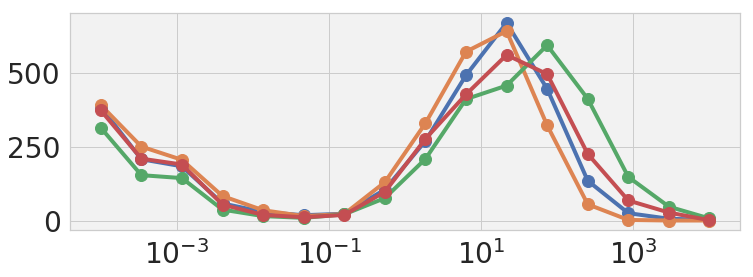

In [46]:
fig=plt.figure(figsize=(12,4))
for k,job in enumerate(joblist):
    best_lambdas = models[job]['lambda']
    plt.plot(lambdas, [np.sum(best_lambdas==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  after removing the cwd from sys.path.


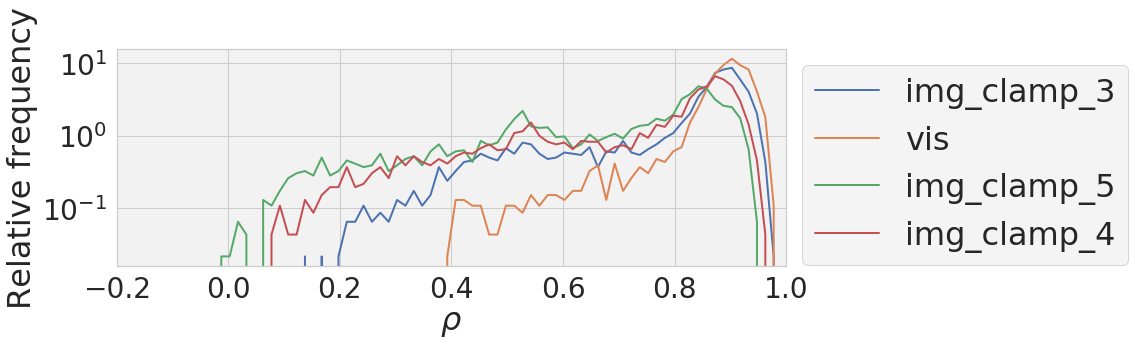

In [47]:
fig=plt.figure(figsize=(12,4))
for k,job in enumerate(joblist):
    val_cc = models[job]['val_cc']
    count, bins = np.histogram(val_cc, bins=100, normed=True, range=(-.5, 1.))
    bin_center = (bins[1:]+bins[:-1])/2
    plt.plot(bin_center, count, lw=2, label=job)
plt.yscale('log')
plt.xlim([-.2, 1.])
plt.xlabel(r'$\rho$')
plt.ylabel('Relative frequency')
plt.legend(loc='upper left', bbox_to_anchor=(1., 1.))

In [48]:
#file_name = '/home/styvesg/Documents/PostDoc/GitRepo/imagery-clean/output/linear_brain_Jan-02-2020_1624_data.pkl'
#
#models_file = open(file_name, 'rb')
#models = pickle.load(models_file)
#models_file.close()
#
#print models.keys()

<a id='result'></a>

# 7. Results

[back to top](#back_to_top)

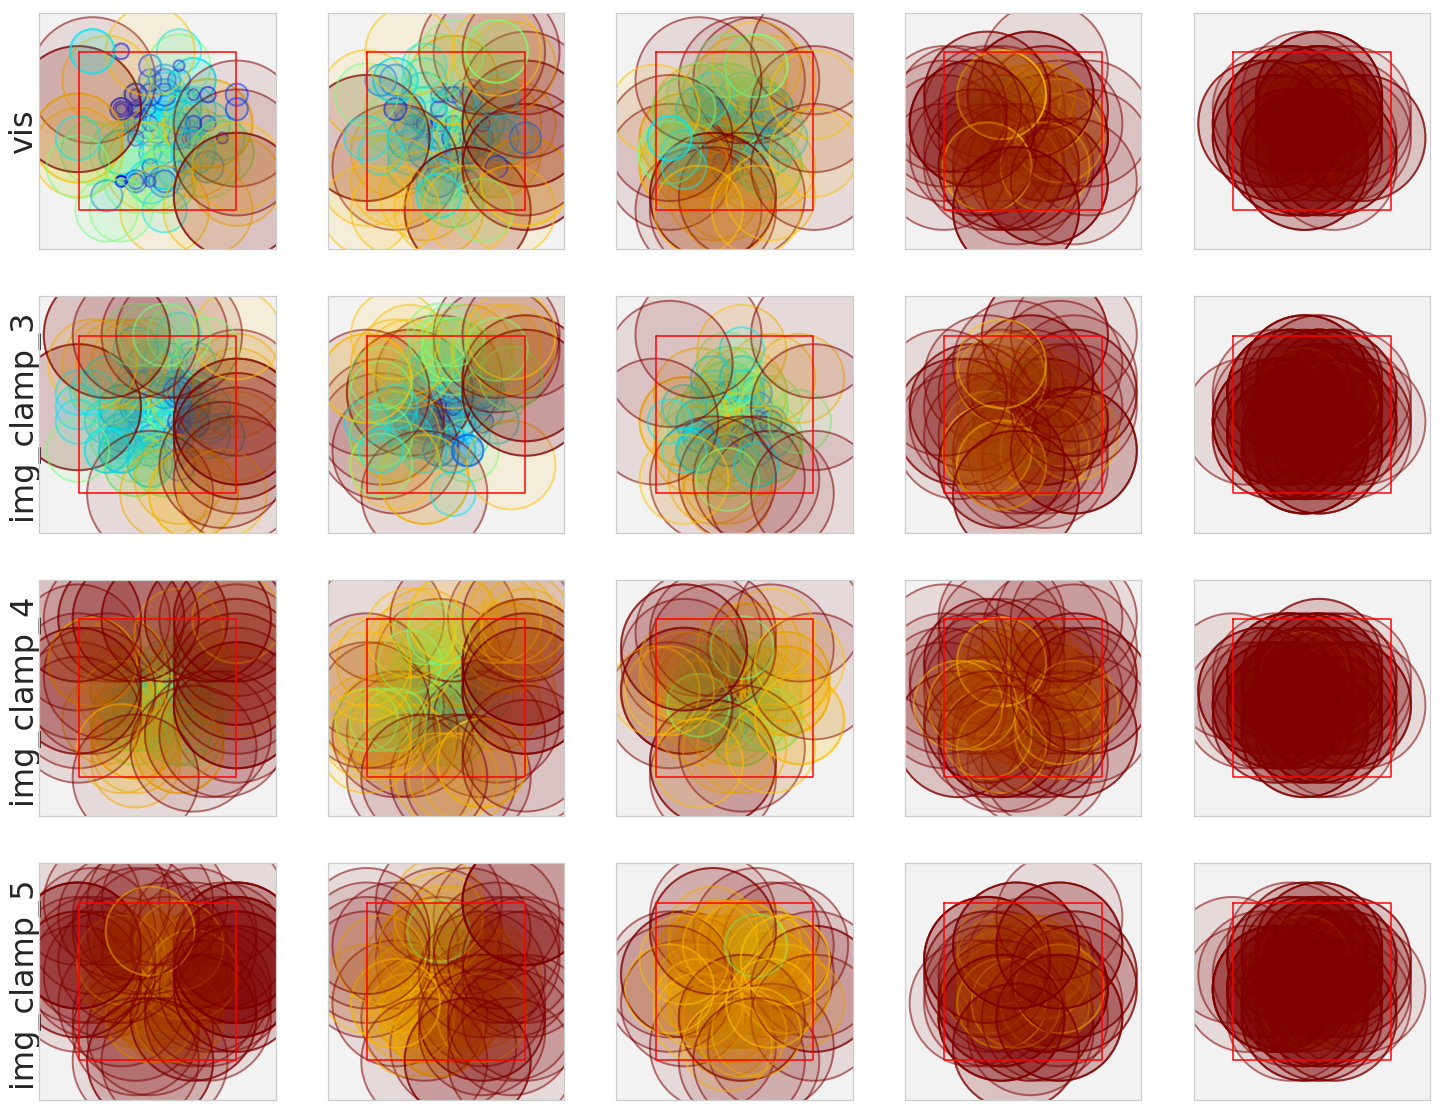

In [58]:
cc_th = 0.7
target_nvox = 120
lx = float(aperture)
nv = np.sum(a_voxel_partitions)

from scipy.stats import rv_discrete
_pruning_dist = lambda x: rv_discrete(name='custm', values=([0,1], [x, 1-x]))
fig=plt.figure(figsize=(5*len(a_roi_mask), 5*len(dspy)))   
for k,job in enumerate(dspy):
    for roi,rm in enumerate(a_roi_mask):
        plt.subplot(len(dspy),len(a_roi_mask), k*len(a_roi_mask)+roi+1)
        val_cc = models[job]['val_cc']
        mask = np.logical_and(rm, val_cc>cc_th)
        roi_nvox = np.sum(mask)
        prune_frac = max(0, float(roi_nvox - target_nvox)) / roi_nvox
        if prune_frac==0:
            print "%d>%d in roi %d" % (target_nvox, roi_nvox, roi)
        pruning_dist = _pruning_dist(prune_frac)
        rand_mask = pruning_dist.rvs(size=rm.shape)    
        mask = np.logical_and(mask, rand_mask)         
        pp.plot_rf_as_circles(models[job]['rf_params'][mask], 0, .4)
        plt.plot([-lx/2,lx/2,lx/2,-lx/2,-lx/2], [lx/2,lx/2,-lx/2,-lx/2, lx/2], 'r')
        plt.xlim([-.75, .75])
        plt.ylim([-.75, .75])
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('')
        if roi==0:
            plt.ylabel(job)
        else:
            plt.ylabel('')

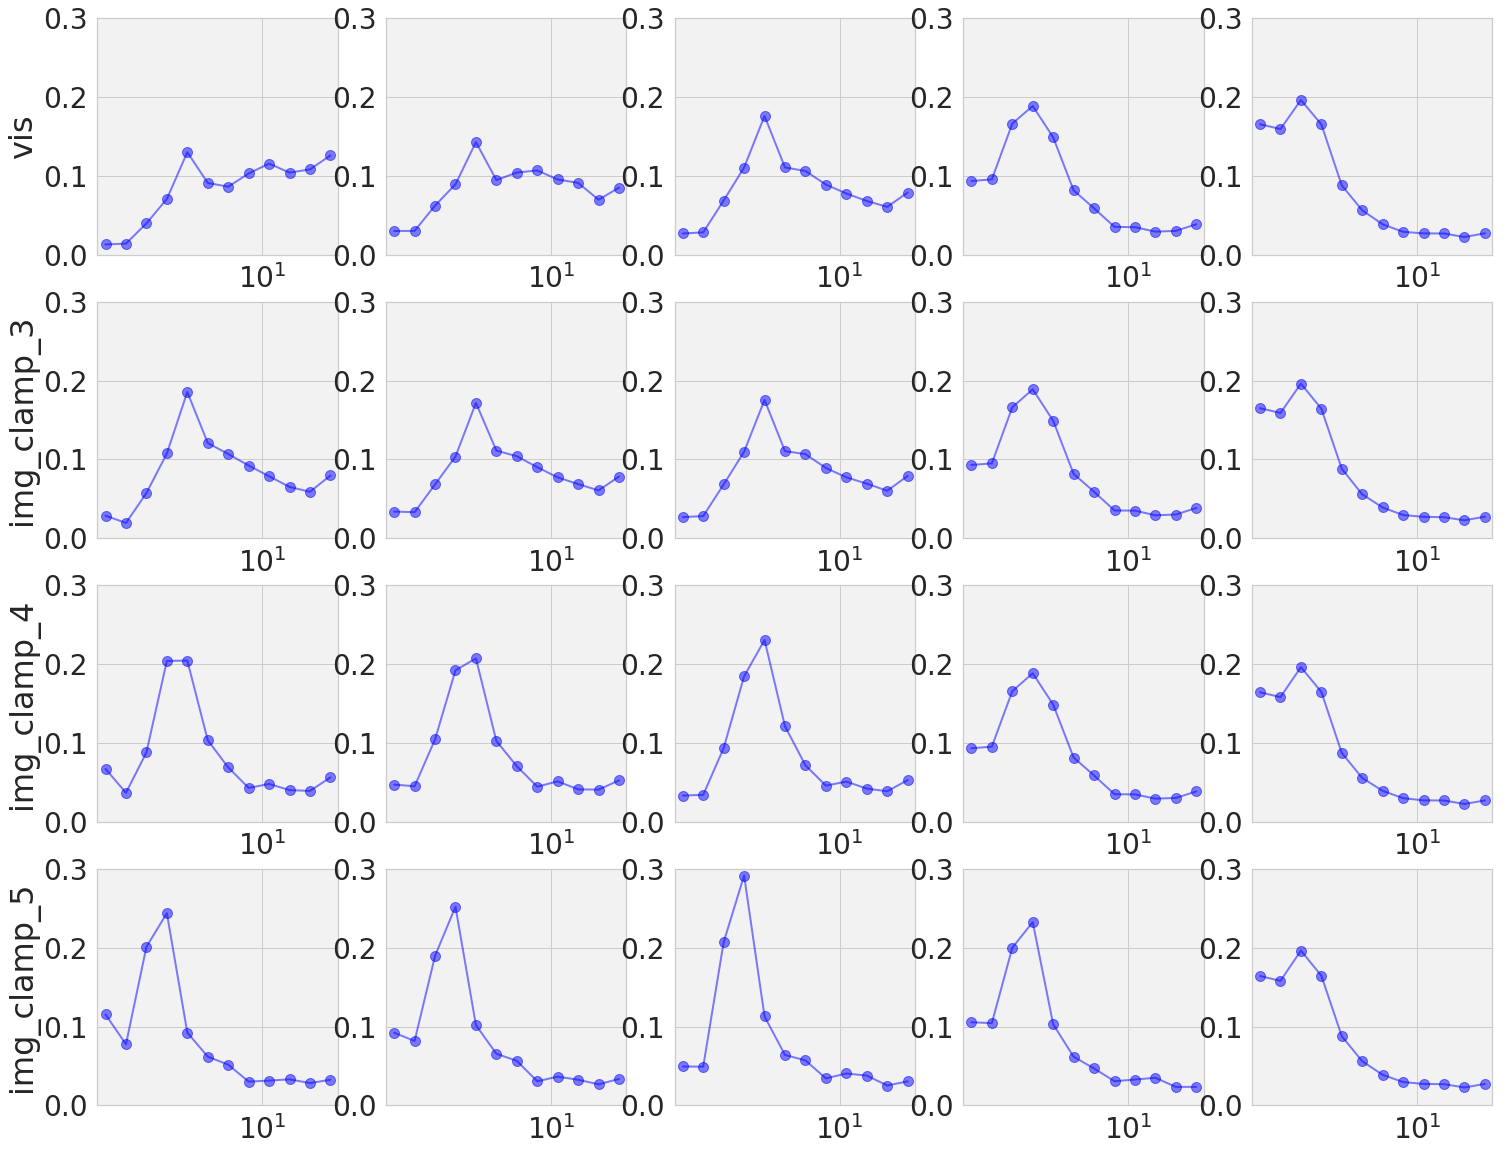

In [59]:
fig=plt.figure(figsize=(5*len(a_roi_mask), 5*len(dspy)))    

for k,job in enumerate(dspy):
    val_cc  = models[job]['val_cc']
    part_cc = models[job]['part_cc']
    rc = np.square(np.nan_to_num(part_cc)) / np.sum(np.square(np.nan_to_num(part_cc)), axis=0, keepdims=True)
    for roi,rm in enumerate(a_roi_mask):
        plt.subplot(len(dspy),len(a_roi_mask), k*len(a_roi_mask)+roi+1)
        #w = np.abs(val_cc[rm])
        mask= np.logical_and(rm, val_cc>cc_th)
        if np.sum(mask):
            #x, y = freq, np.sum(w[np.newaxis,:]*rc[:,rm],axis=1)/np.sum(w)
            x, y = freq, np.average(rc[:,mask], weights=np.square(val_cc)[mask], axis=1)
            plt.plot(x, y, marker='o', color='b', ms=10, lw=2, alpha=0.5)   
            plt.ylim([0, .3])
            plt.xlim([0.9*freq[0], 1.1*freq[-1]])
            plt.xscale('log')
            if roi==0:
                plt.ylabel(job)
            else:
                plt.ylabel('')    
    #plt.xticks([])
    #plt.yticks([])

(-0.01, 0.07)

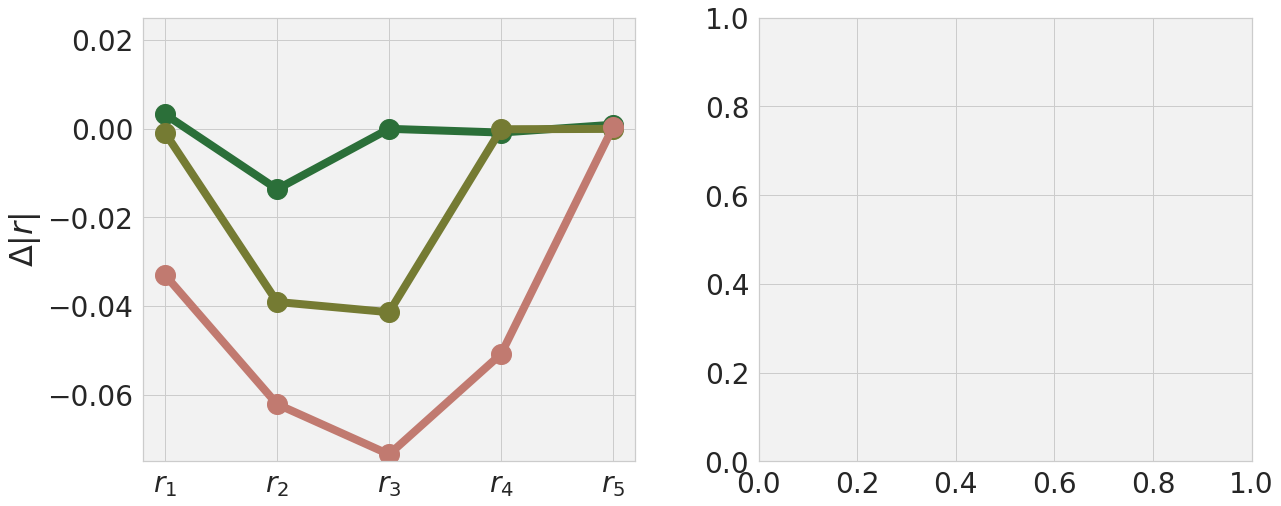

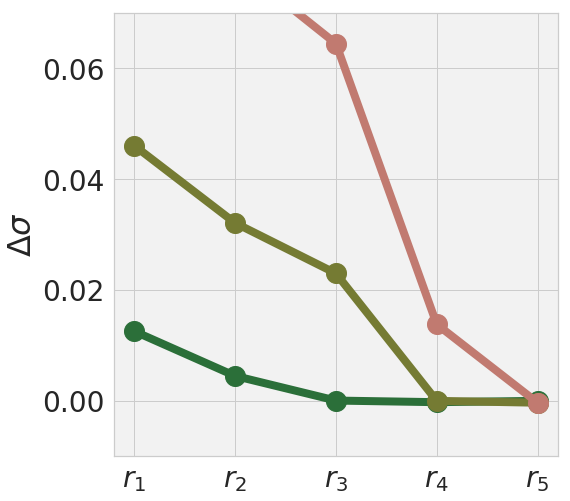

In [60]:
ref_rf = models[vref]['rf_params']
ref_ecc = np.sqrt(np.square(ref_rf[:,0])+np.square(ref_rf[:,1]))
fig=plt.figure(figsize=(20, 8))
plt.subplots_adjust(left=.18, bottom=.18, right=0.95, top=0.95, wspace=0.25, hspace=0.)
plt.subplot(1,2,1)
for k,cm in enumerate(cmps):
    val_cc  = models[cm]['val_cc']
    decc = np.sqrt(np.square(models[cm]['rf_params'][:,0]) + np.square(models[cm]['rf_params'][:,1])) - ref_ecc
    roi_shift = []
    for roi,rm in enumerate(a_roi_mask):  
        mask = np.logical_and(rm, val_cc>cc_th) 
        if np.sum(mask):
            roi_shift += [np.average(decc[mask], weights=np.square(val_cc)[mask]),]
        else:
            roi_shift += [np.nan,]
    plt.plot(roi_shift, color=sns.color_palette("cubehelix", 8)[clri[cm]], lw=8, marker='o', ms=20)
_=plt.gca().set_xticks([0,1,2,3,4])
_=plt.gca().set_xticklabels(['$r_1$', '$r_2$', '$r_3$', '$r_4$', '$r_5$'])
_=plt.ylabel(r'$\Delta |r|$')
plt.ylim([-.075, .025])
#####################################################################
plt.subplot(1,2,2)
ref_rf = models[vref]['rf_params']
ref_ecc = ref_rf[:,2]
fig=plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=.18, bottom=.18, right=0.95, top=0.95, wspace=0.25, hspace=0.)
for k,cm in enumerate(cmps):
    val_cc  = models[cm]['val_cc']
    decc = models[cm]['rf_params'][:,2] - ref_ecc
    roi_shift = []
    for roi,rm in enumerate(a_roi_mask):  
        mask = np.logical_and(rm, val_cc>cc_th)
        if np.sum(mask):
            roi_shift += [np.average(decc[mask], weights=np.square(val_cc)[mask]),]
        else:
            roi_shift += [np.nan,]
    plt.plot(roi_shift, color=sns.color_palette("cubehelix", 8)[clri[cm]], lw=8, marker='o', ms=20)
_=plt.gca().set_xticks([0,1,2,3,4])
_=plt.gca().set_xticklabels(['$r_1$', '$r_2$', '$r_3$', '$r_4$', '$r_5$'])
plt.ylabel(r'$\Delta\sigma$')
plt.ylim([-.01, 0.07])

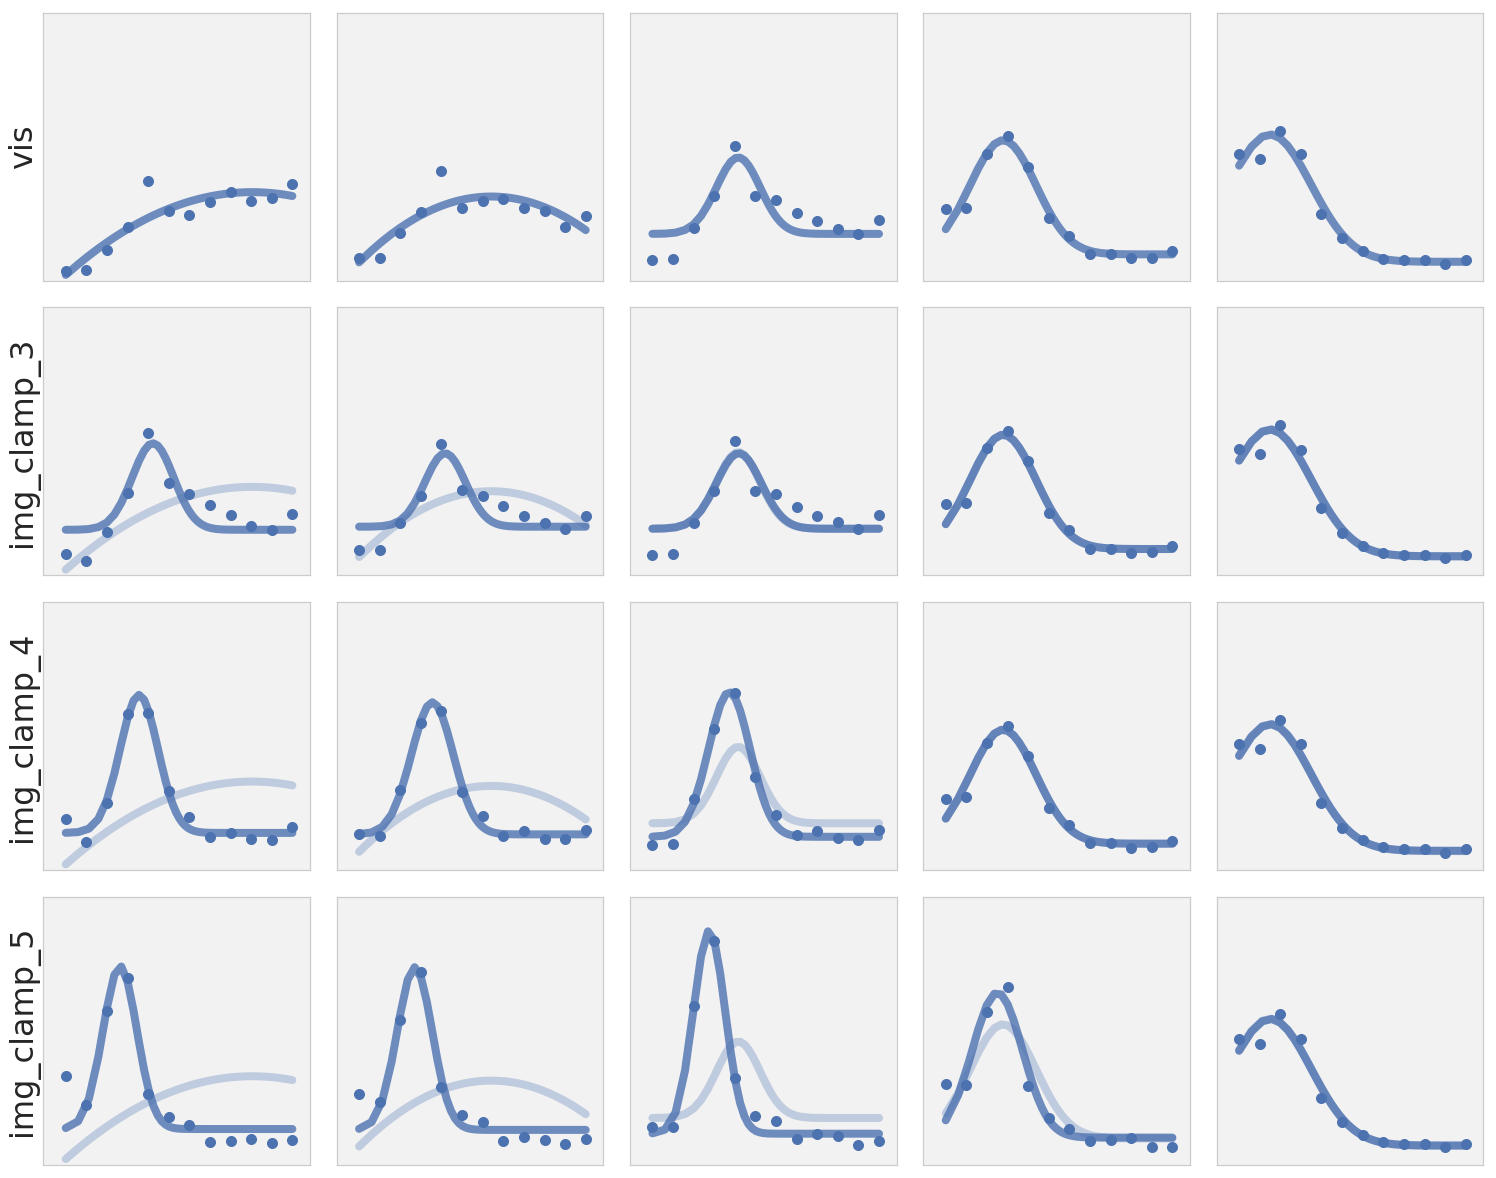

In [61]:
x = freq
xi = np.linspace(x[0], x[-1], 100)
a = (np.log(x)[-1]-np.log(x)[0])/len(x)
b = np.log(x)[0]
dx = np.array([(np.exp(b+(i+0.5)*a) - np.exp(b+(i-0.5)*a)) for i in range(len(x))]) # invervals?

from scipy.optimize import curve_fit
def tuning_func(omega, a, b, sigma, omega0):
    return b+a * np.exp(-np.square(np.log(omega)-np.log(omega0))/2/sigma**2)

tuning_curves = {}
fig3c = plt.figure(figsize=(5*len(a_roi_mask), 5*len(dspy)))
plt.subplots_adjust(left=.15, bottom=.15, right=0.95, top=0.95, wspace=0.1, hspace=0.1)
for i,m in enumerate(dspy):
    val_cc  = models[m]['val_cc']
    part_cc = models[m]['part_cc']
    rc = np.square(np.nan_to_num(part_cc)) / np.sum(np.square(np.nan_to_num(part_cc)), axis=0, keepdims=True)
    tuning_curves[m] = {}
    tuning_curves[m]['popt'] = []
    tuning_curves[m]['pvar'] = []
    for k,rm in enumerate(a_roi_mask):
        plt.subplot(len(dspy),len(a_roi_mask),i*len(a_roi_mask)+k+1)
        mask = np.logical_and(rm, val_cc>cc_th)
        x, y = freq, np.average(rc[:,mask], weights=np.square(val_cc)[mask], axis=1) # / dx
        p=plt.plot(x, y, marker='o', linestyle='None', ms=10, lw=6, label=n) 
        try:
            popt, pcov = curve_fit(tuning_func, x, y, p0=[.1, 0.01, 10., 15.])       
        except:
            popt, pcov = [0., 0.0, 50., 10.], np.zeros(shape=(4,4)) 
            _=plt.plot(xi, tuning_func(xi, *popt), color='red', linestyle='-', lw=8, alpha=0.8)  
        finally:
            tuning_curves[m]['popt'] += [popt,]
            tuning_curves[m]['pvar'] += [np.diag(pcov),]
            _=plt.plot(xi, tuning_func(xi, *popt), color=p[0].get_color(), linestyle='-', lw=8, alpha=0.8)      
        if m is not 'vis':
            popt_vis = tuning_curves['vis']['popt'][k]
            _=plt.plot(xi, tuning_func(xi, *popt_vis), color=p[0].get_color(), linestyle='-', lw=8, alpha=0.3)             
       
        if k==0:
            plt.ylabel(m)
        plt.xscale('log')
        plt.xlim(1., 30.)
        plt.ylim([0, .35])   
        plt.xticks([])
        plt.yticks([])

(-15.0, 4.0)

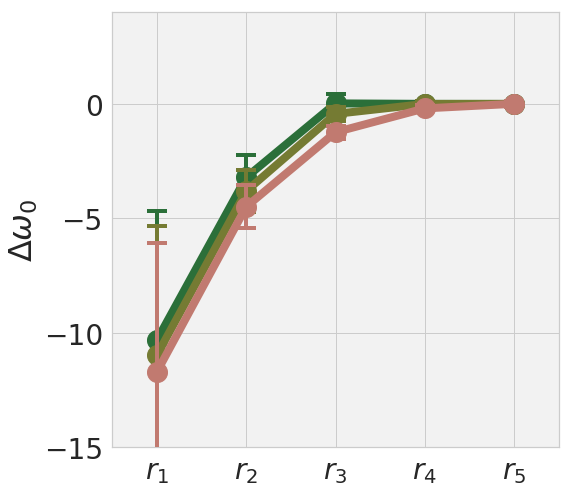

In [62]:
fig=plt.figure(figsize=(8,8))
ref_f = np.array(tuning_curves[vref]['popt'])[:,3]
ref_d = np.array(tuning_curves[vref]['pvar'])[:,3]
for k,cm in enumerate(cmps):
    f = np.array(tuning_curves[cm]['popt'])[:,3]
    d = np.array(tuning_curves[cm]['pvar'])[:,3]

    p=plt.errorbar(np.arange(len(f)), f-ref_f, yerr=np.sqrt(d+ref_d), color=sns.color_palette("cubehelix", 8)[clri[cm]], marker='o', ms=20, lw=8, elinewidth=4, capsize=10, capthick=4, zorder=k+1)    
_=plt.gca().set_xticks([0,1,2,3,4])
_=plt.gca().set_xticklabels([r'$r_1$', r'$r_2$', r'$r_3$', r'$r_4$', r'$r_5$'])
#plt.yscale('log')
plt.xlim([-.5,4.5])
plt.ylabel(r'$\Delta\omega_0$')
plt.ylim([-15.,4.])